In [1]:
import torch
import numpy as np
import pandas as pd

from src.data.core import GetData
from src.data import DataBlock
from typing import Literal
from copy import deepcopy
import torch
import torch.nn.functional as F

from src.factor.plot_util import FactorStatPlot

class DataVendor:
    def __init__(self):
        self.start_dt = 99991231
        self.end_dt   = -1
        self.max_date   = GetData.data_dates('trade' , 'day')[-1]
        self.trade_date = GetData.trade_dates()
        self.all_stocks = GetData.stocks().sort_values('secid')

    def td_within(self , start_dt : int = -1 , end_dt : int = 99991231 , step : int = 1):
        return self.trade_date[(self.trade_date >= start_dt) & (self.trade_date <= end_dt)][::step]

    def td_offset(self , date , offset : int = 0):
        if np.isscalar(date):
            if date not in self.trade_date: date = self.trade_date[self.trade_date <= date][-1]
            d = self.trade_date[np.where(self.trade_date == date)[0][0] + offset]
            return int(d)
        else:
            return np.array([self.td_offset(d , offset) for d in date])

    def random_factor(self):
        date  = self.td_within(20240101,20240531,5)
        secid = self.all_stocks.secid
        factor_val = DataBlock(np.random.randn(len(secid),len(date),1,2),secid,date,['factor1','factor2'])
        return factor_val

    def get_returns(self , start_dt : int , end_dt : int):
        if self.start_dt > start_dt or self.end_dt < end_dt:
            self.start_dt = min(start_dt , self.start_dt)
            self.end_dt   = max(end_dt , self.end_dt)
            self.day_ret  = GetData.daily_returns(self.start_dt , self.end_dt)

    def nday_fut_ret(self , secid : np.ndarray , date : np.ndarray , nday : int = 10 , lag : int = 2 , 
                     ret_type : Literal['close' , 'vwap'] = 'close'):
        assert lag > 0 , f'lag must be positive : {lag}'
        date_min  = int(self.td_offset(date.min() , -10))
        date_max  = min(int(self.td_offset(int(date.max()) , nday + lag + 10)) , self.max_date)
        full_date = self.td_within(date_min , date_max)
        self.get_returns(date.min() , int(date_max))
        block = self.day_ret.align(secid , full_date , [ret_type] , inplace=False).as_tensor()
        block.values = F.pad(block.values[:,lag:] , (0,0,0,0,0,lag) , value = torch.nan)

        new_value = block.values.unfold(1 , nday , 1).exp().prod(dim = -1) - 1
        feature   = ['ret']

        new_block = DataBlock(new_value , secid , full_date[:new_value.shape[1]] , feature).align_date(date)
        return new_block

In [2]:
from typing import Literal , Optional 

from src.data.fetcher import get_target_dates , load_target_file
from src.func import match_values

class Portfolio:
    def __init__(self , port : Optional[pd.DataFrame] , date : int = -1 , name : str = 'port') -> None:
        self.exists = port is not None 
        self.port = self.empty_port if port is None else port.groupby('secid')['weight'].sum().reset_index() 
        self.date = date
        self.name = name

    def __repr__(self): return repr(self.port)

    @classmethod
    def random(cls):
        date = np.random.randint(20200101 , 20231231)
        name = 'rand_port'
        port = pd.DataFrame({'secid' : np.arange(1,101) , 'weight' : np.random.rand(100)})
        return cls(port,date,name)

    @property
    def empty_port(self):
        return pd.DataFrame(columns=['secid','weight']).astype({'secid':int,'weight':float})
    
    @property
    def port_with_date(self):
        if len(self.port):
            return pd.DataFrame({'date':self.date , **self.port})
        else:
            return pd.DataFrame(columns=['date','secid','weight']).astype({'date':int,'secid':int,'weight':float})
        
    @property
    def secid(self): return self.port['secid'].to_numpy()
    @property
    def weight(self): return self.port['weight'].to_numpy()
    
class PortfolioStream:
    def __init__(self , portfolios : list[Portfolio] = []) -> None:
        self.ports = {f'{port.name}.{port.date}':port for port in portfolios}
        self.create_weight_block()

    def __repr__(self): return repr(self.ports)

    @classmethod
    def random(cls):  return cls([Portfolio.random() for _ in range(3)])

    def create_weight_block(self):
        secid = np.unique(np.concatenate([port.secid for port in self.ports.values()])) if self.ports else np.array([]).astype(int)
        date  = np.array([port.date for port in self.ports.values()]).astype(int)
        values = np.zeros((len(secid) , len(date) , 1 , 1))
        for i , port in enumerate(self.ports.values()):
            values[match_values(port.secid , secid),i,0,0] = port.weight
        self.weight = DataBlock(values , secid , date , ['weight']).align_date(np.sort(date))

    def stack(self):
        if self.ports:
            return pd.concat([pf.port_with_date for pf in self.ports.values()] , axis = 0)
        else:
            return pd.DataFrame(columns=['date','secid','weight']).astype({'date':int,'secid':int,'weight':float})
        
    def append(self , port : Portfolio):
        key = f'{port.name}.{port.date}'
        assert key not in self.ports.keys() , key
        self.ports[key] = port
        new_secid = np.union1d(self.weight.secid , port.secid)
        new_date  = np.union1d(self.weight.date  , port.date)
        self.weight = self.weight.align_secid_date(new_secid , new_date)
        i = match_values(port.secid , self.weight.secid)
        j = np.where(new_date == port.date)[0][0]
        self.weight.values[i,j,0,0] = port.weight[:]


    def get(self , name : str , date : int):
        key = f'{name}.{date}'
        return self.ports.get(key , None)

pf = Portfolio.random().port_with_date

In [3]:
from typing import Literal , Optional 

from src.data.fetcher import get_target_dates , load_target_file

class Benchmark:
    def __init__(self , name : Optional[Literal['csi300' , 'csi500' , 'csi1000']] = None) -> None:
        self.name = name
        if self.name is None:
            self.available_dates = None
        else:
            self.available_dates = get_target_dates('benchmark' , self.name)
        self.ports = PortfolioStream()

    def latest_avail_date(self , date : int = 99991231):
        if self.available_dates is None: return None
        if date in self.available_dates: return date
        tar_dates = self.available_dates[self.available_dates < date]
        return max(tar_dates) if len(tar_dates) else -1

    def get(self , date : int , latest = False):
        if self.name is None: return Portfolio(None , date , 'none')
        if (bm := self.ports.get(self.name , date)) is not None: return bm
        bm = load_target_file('benchmark' , self.name , date)
        if bm is None and latest: bm = load_target_file('benchmark' , self.name , self.latest_avail_date(date))
        port = Portfolio(bm , date , self.name)
        self.ports.append(port)
        return port

    def universe(self , secid : np.ndarray , date : np.ndarray):
        for i , d in enumerate(date): self.get(d , latest = i==0)
        weight = self.ports.weight.copy().align_secid_date(secid , date).as_tensor()
        weight.values = weight.values.nan_to_num(0) > 0
        weight.feature = ['universe']
        return weight
    
bm = Benchmark('csi300')
# bm.get(20240601 , True)

      secid   weight
0         1  0.00593
1         2  0.00309
2        63  0.00473
3        69  0.00070
4       100  0.00442
..      ...      ...
295  688363  0.00062
296  688396  0.00111
297  688561  0.00039
298  688599  0.00132
299  688981  0.00487

[300 rows x 2 columns]

In [43]:
vendor = DataVendor()
factor_val = vendor.random_factor().to_dataframe()
benchmark  = Benchmark('csi300')

def factor_val_breakdown(factor_val : DataBlock | pd.DataFrame):
    if isinstance(factor_val , DataBlock):
        secid , date = factor_val.secid , factor_val.date
        df = factor_val.to_dataframe()
    else:
        df = factor_val
        secid = factor_val.index.get_level_values('secid').unique().values
        date  = factor_val.index.get_level_values('date').unique().values
    return df , secid , date

def calc_ic(factor_val : DataBlock | pd.DataFrame , nday : int = 10 , lag : int = 2 , 
            ic_type  : Literal['pearson' , 'spearman'] = 'pearson' ,
            ret_type : Literal['close' , 'vwap'] = 'close'):
    factor_val , secid , date = factor_val_breakdown(factor_val)
    factor_ret = vendor.nday_fut_ret(secid , date , nday , lag , ret_type = ret_type).to_dataframe()
    factor_list = factor_val.columns.tolist()
    factor_val = factor_val.join(factor_ret)
    ic = factor_val.groupby(by=['date'], as_index=True).apply(
        lambda x: x[factor_list].corrwith(x['ret'], method=ic_type))
    return ic

def calc_grp_avg(x : pd.DataFrame , x_column : list, y_name : str = 'ret', group_num : int = 10):
    y = pd.DataFrame(x[y_name], index=x.index, columns=[y_name])
    rtn = list()
    for x_name in x_column:
        y['group'] = pd.qcut(x[x_name], group_num, labels=[f'group{i}' for i in range(1, group_num + 1)])
        grp_avg_ret = y.groupby('group' , observed = True)[y_name].mean().rename(x_name)
        rtn.append(grp_avg_ret)
    rtn = pd.concat(rtn, axis=1, sort=True)
    return rtn

def calc_grp_perf(factor_val : DataBlock | pd.DataFrame, nday : int = 10 , lag : int = 2 , group_num : int = 10 ,
                  ret_type : Literal['close' , 'vwap'] = 'close'):
    factor_val , secid , date = factor_val_breakdown(factor_val)
    factor_ret = vendor.nday_fut_ret(secid , date , nday , lag , ret_type = ret_type).to_dataframe()
    factor_list = factor_val.columns.tolist()
    factor_ret = factor_ret.merge(factor_val , on = ['secid','date'])
    df = factor_ret.groupby('date').apply(calc_grp_avg , x_column = factor_list , y_name = 'ret' , group_num = group_num) # type: ignore
    return df.rename_axis('factor_name', axis='columns').stack().rename('group_ret').reset_index().sort_values(['date','group'])

def factor_mask(factor_val : DataBlock | pd.DataFrame , benchmark : Optional[Benchmark] = None):
    factor_val , secid , date = factor_val_breakdown(factor_val)
    if benchmark is None or benchmark.name is None: return factor_val
    factor_list = factor_val.columns.to_list()
    univ = benchmark.universe(secid , date).to_dataframe()
    factor_val = factor_val.join(univ)
    factor_val.loc[~factor_val['universe'] , factor_list] = np.nan
    del factor_val['universe']
    return factor_val.dropna()

In [44]:
g = calc_grp_perf(factor_val)
fig = FactorStatPlot.plot_group_perf(g)

[<Figure size 1600x700 with 1 Axes>, <Figure size 1600x700 with 1 Axes>]

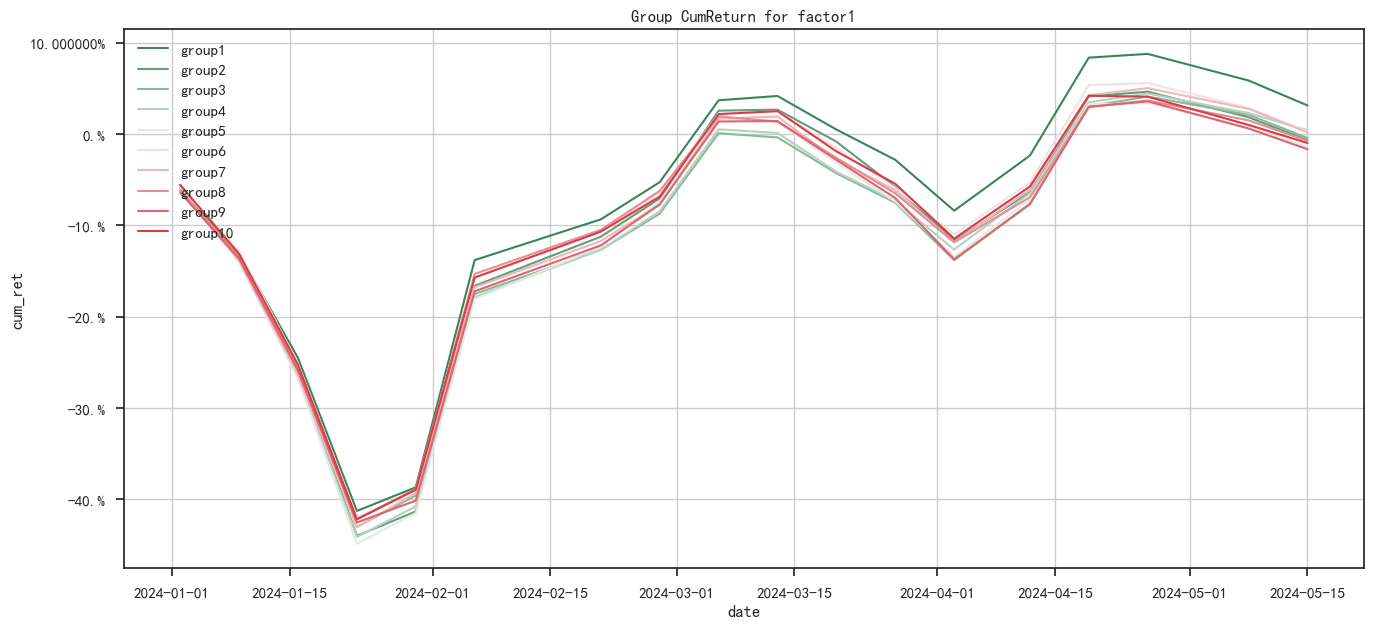

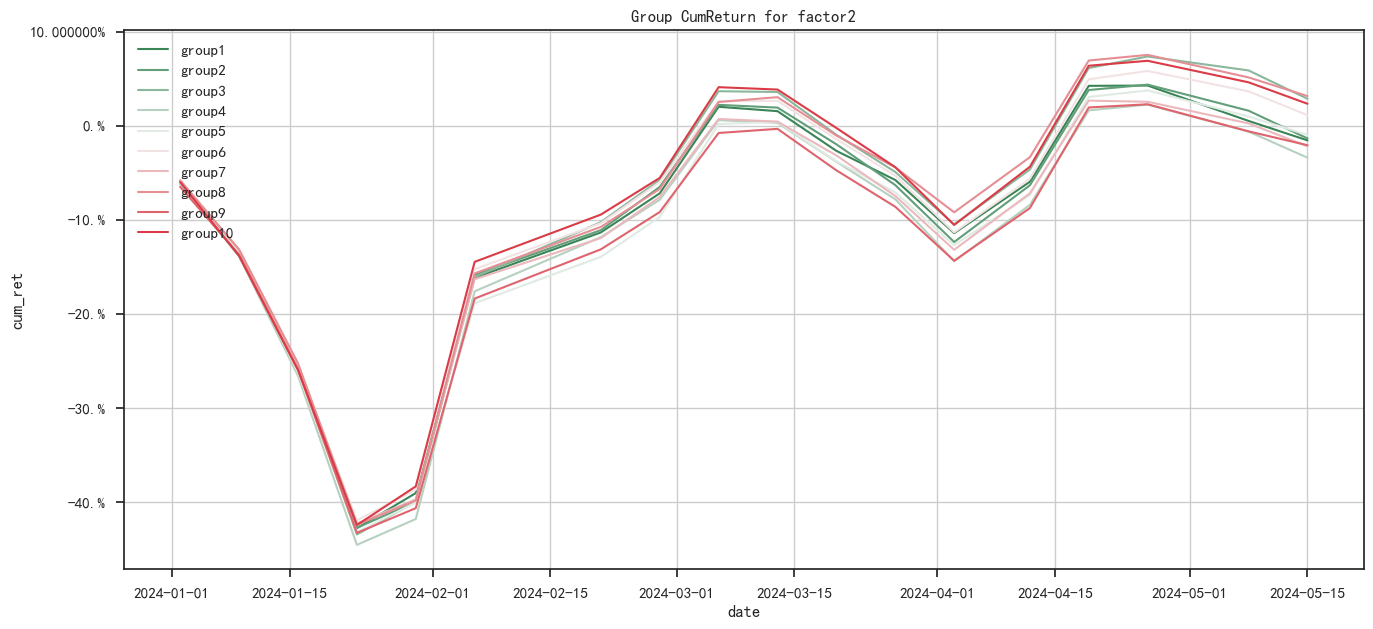

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from packaging import version

# for Chinese
sns.set_theme(context='notebook', style='ticks', font='SimHei', rc={'axes.unicode_minus': False})
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def pct_fmt(temp : float, position : int = 2): return f'{np.format_float_positional(temp * 100 , position)}%'

def plot_group_perf(grp_perf : pd.DataFrame , factor_name : Optional[str] = None):
    if factor_name is None:
        factor_list = grp_perf['factor_name'].unique()
        return [plot_group_perf(grp_perf , factor_name) for factor_name in factor_list]
    else:
        grp_cum_ret = grp_perf[grp_perf['factor_name'] == factor_name].drop(columns=['factor_name']).\
            set_index(['date', 'group']).groupby('group' , observed=False)['group_ret'].\
            cumsum().rename('cum_ret').reset_index(drop=False)
        grp_cum_ret = grp_cum_ret.assign(date=pd.to_datetime(grp_cum_ret['date'].astype(str), format='%Y%m%d'))
        fig = plt.figure(figsize=(16, 7))
        if version.Version(getattr(sns , '__version__')) > version.Version('0.9.1'):
            ax = sns.lineplot(x='date', y='cum_ret', hue='group', data=grp_cum_ret,
                            palette=sns.diverging_palette(140, 10, sep=10, n=grp_cum_ret['group'].nunique()))
        else:
            ax = sns.lineplot(x='date', y='cum_ret', hue='group', data=grp_cum_ret)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[0:], labels=labels[0:], loc='upper left')
        plt.grid()
        plt.gca().yaxis.set_major_formatter(FuncFormatter(pct_fmt))
        ax.set_title(f'Group CumReturn for {factor_name}')
        return fig
    
FactorStatPlot.plot_group_perf(g)

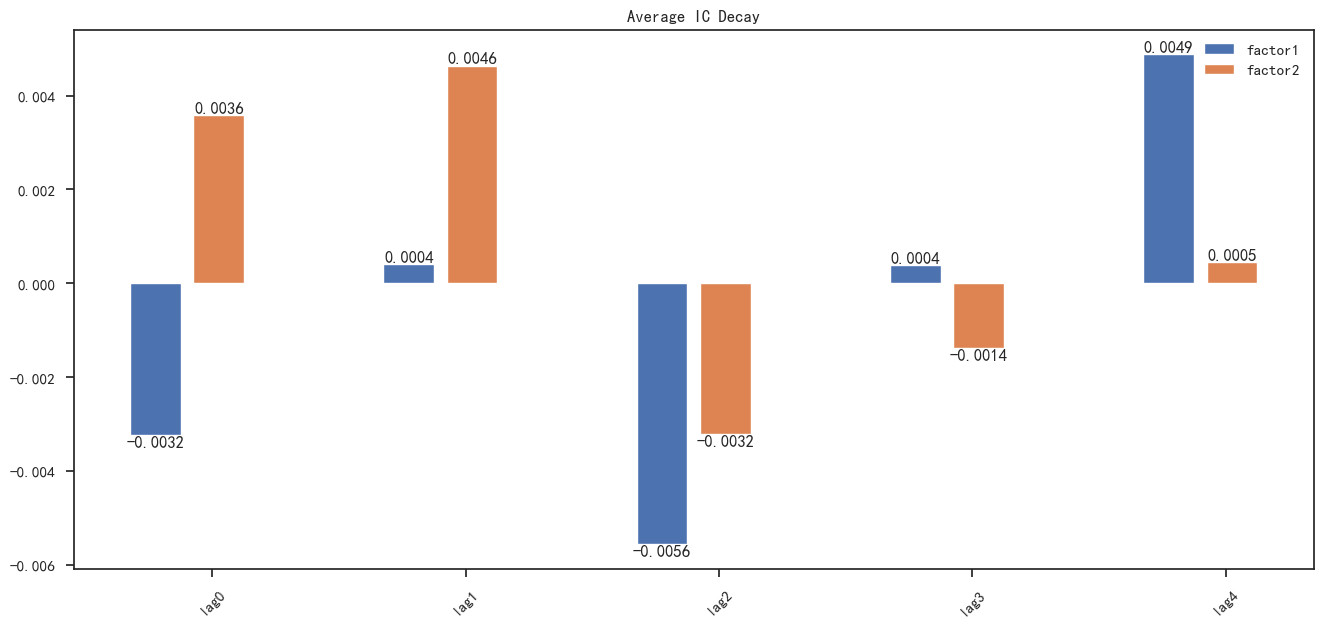

In [55]:


def calc_decay_pnl(factor_val : DataBlock | pd.DataFrame, nday : int = 10 , lag_init : int = 2 , lag_num : int = 5 ,
                   benchmark : Optional[Benchmark] = None , ic_type : Literal['pearson' , 'spearman'] = 'pearson' , 
                   ret_type : Literal['close' , 'vwap'] = 'close'):
    '''
    nday : days of future return
    lag_init : starting lag of most recent future return , usually 1 or 2
    lag_num  : how many lagging period to calculate ic
    benchmark : within some benchmark
    '''
    decay_pnl_df = []
    factor_val = factor_mask(factor_val , benchmark)
    for lag in range(lag_num):
        decay_pnl = calc_ic(factor_val, nday , lag_init + lag * nday , ic_type = ic_type , ret_type = ret_type)
        decay_pnl_df.append(pd.DataFrame({'lag_type':f'lag{lag}','ic_mean':decay_pnl.mean()}))
    decay_pnl_df = pd.concat(decay_pnl_df, axis=0)
    return decay_pnl_df.reset_index().rename(columns={'index':'factor_name'})

a = calc_decay_pnl(factor_val)
fig= FactorStatPlot.plot_decay_ic(a)

In [32]:
def calc_decay_grp_perf(factor_val : DataBlock | pd.DataFrame, nday : int = 10 , lag_init : int = 2 , group_num : int = 10 ,
                        lag_num : int = 5 , benchmark : Optional[Benchmark] = None , ret_type : Literal['close' , 'vwap'] = 'close'):
    decay_grp_perf = []
    factor_val = factor_mask(factor_val , benchmark)
    for lag in range(lag_num):
        grp_perf = calc_grp_perf(factor_val , nday , lag_init + lag * nday , group_num , ret_type = ret_type)
        decay_grp_perf.append(pd.DataFrame({'lag_type':f'lag{lag}',**grp_perf}))
    
    decay_grp_perf = pd.concat(decay_grp_perf, axis=0).reset_index()

    n_periods  = 243 / nday
    group_cols = ['factor_name', 'group', 'lag_type']
    decay_grp_ret_mean = decay_grp_perf.groupby(group_cols,observed=False)['group_ret'].mean() * n_periods
    deacy_grp_ret_std  = decay_grp_perf.groupby(group_cols,observed=False)['group_ret'].std() * np.sqrt(n_periods)
    decay_grp_ret_ir   = decay_grp_ret_mean / deacy_grp_ret_std
    rtn = pd.concat([decay_grp_ret_mean.rename('decay_grp_ret'),decay_grp_ret_ir.rename('decay_grp_ir')], axis=1, sort=True)
    rtn = pd.DataFrame(rtn.rename_axis('stats_name', axis='columns').stack() , columns=['stats_value']).reset_index(drop=False)
    return rtn

a = calc_decay_grp_perf(factor_val)
fig = FactorStatPlot.plot_decay_grp_perf(a , 'ir' , 'factor1')

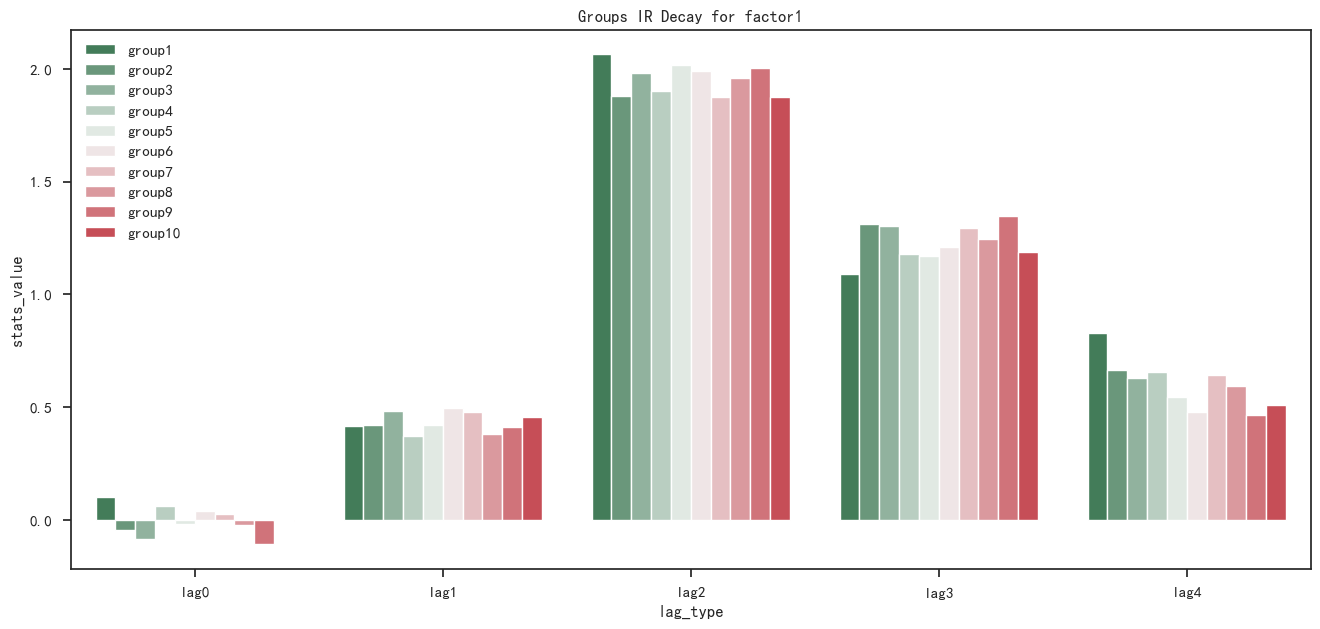

In [42]:
fig = FactorStatPlot.plot_decay_grp_perf(a , 'ir' , 'factor1')

In [1]:
from src.data.fetcher import DataFetcher
DataFetcher('benchmark' , 'csi300').source_dates()

array([20050104, 20050105, 20050106, ..., 20240531, 20240603, 20240604])